# Emotion recognition with MobileNet

In this portion of the assignment, I will leverage a pre-trained model (based on MobileNet architecture) for the task of emotion recognition.

**[Give an overview about the advantages and differences of the model]**

## Hardware Check (GPU vs CPU)

In [1]:
import tensorflow as tf

# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the GPU:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Import the libraries and dataset

In [152]:
from datasets import load_dataset               # Function to load a dataset from the HuggingFace database
import matplotlib.pyplot as plt
import numpy as np                              #
from numpy import round, sqrt 
from numpy import random                        # For showing a random array of images from the dataset
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import Sequence
import keras
from keras.applications import mobilenet, MobileNet
from keras.applications import vgg16
# from keras.applications.vgg16 import VGG16, preprocess_input

tf.get_logger().setLevel('ERROR')

dataset_raw = load_dataset("FastJobs/Visual_Emotional_Analysis")
num_data = dataset_raw['train'].shape[0]

# Number of unique labels
num_classes = len(set(dataset_raw['train']['label']))
# Dimension of the input images (taken a single image)
image_dim = np.array(dataset_raw['train']['image'][0]).shape
labels = dataset_raw["train"].features["label"].names

# Dictionary to decode the meaning of the numerical labels
label_dict = {}

for i, label in enumerate(labels):
    label_dict[i] = label

Make a train-test split to separate the training+validation data from the holdout set

In [4]:
# Split the raw dataset into a train set and a test set
train_dataset, test_dataset = dataset_raw['train'].train_test_split(test_size=0.15).values()

# Further split the training set into training and validation sets
train_dataset, val_dataset = train_dataset.train_test_split(test_size=0.1).values()

# print(dataset_split)


num_train = len(train_dataset['image'])
num_val = len(val_dataset['image'])
# num_train = dataset_split['train'].shape[0]
num_test = len(test_dataset['image'])
# num_test = dataset_split['test'].shape[0]

# Print the number of samples in each set
print(f"There are {num_train} samples in the training set \n"
      f"There are {num_val} sampels in the validation set \n"
      f"There are {num_test} samples in the testing set")



There are 612 samples in the training set 
There are 68 sampels in the validation set 
There are 120 samples in the testing set


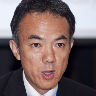

In [5]:
train_dataset['image'][0]

## Data discovery
Display some examples from the training dataset

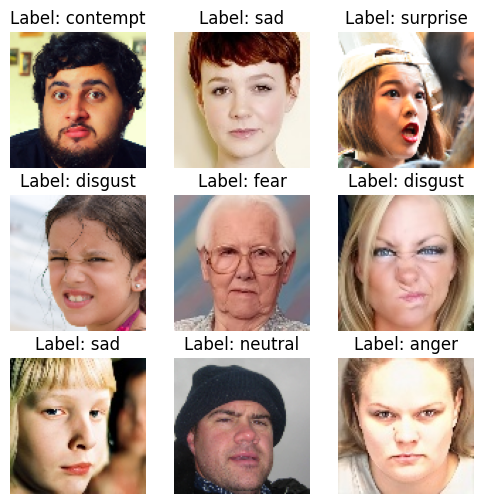

In [6]:
num_samples = 9                                                                             # number of samples to be display
num_rows = np.int8(round(sqrt(num_samples))); num_cols = np.int8(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_train,size = (num_samples))                                       # random index for choosing the samples in the dataset

# Sample random images and their indices
image_rand = train_dataset[rand]['image']
label_rand = train_dataset[rand]['label']

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        image = image_rand[index]  # Extract the image
        label = label_rand[index]  # Extract the label

        ax = axes[i,j]
        # Display the image
        ax.imshow(image)
        ax.set_title(f"Label: {label_dict[label]}")
        ax.axis("off")

To investigate the dimension of an image in this dataset, the image first need to be converted to a numpy array. The code block below shows that dimension of each image in terms of width x height x depth

In [7]:
# Let's take a random image from the sample
image = image_rand[random.randint(num_samples)]

# Dimension of the PIL image
print(f"The 2D size of the image is {image.size}\n"
      f"The depth of the image can be inferred from the image mode: {image.mode}\n")

# Dimension of the image_array
image_array = np.array(image)
image_dim = image_array.shape
print(f"Once converted to a numpy array, we can explicitly see the 3D size as \n{image_dim}")


The 2D size of the image is (96, 96)
The depth of the image can be inferred from the image mode: RGB

Once converted to a numpy array, we can explicitly see the 3D size as 
(96, 96, 3)


## Data Unpacking

The function below extract each images from the list of PIL images. Each image is converted to an numpy array, and the list of these np arrays are converted to a big numpy array, containing the batch and image shape information

In [8]:
def pil_images_to_numpy(images):
    image_arrays = [np.array(img) for img in images]
    return np.array(image_arrays)

Convert the train/validation/test set and the corresponding categories (image/label) to their own numpy array

In [76]:
image_train_array = pil_images_to_numpy(train_dataset['image'])
label_train_array = pil_images_to_numpy(train_dataset['label'])
image_val_array = pil_images_to_numpy(val_dataset['image'])
label_val_array = pil_images_to_numpy(val_dataset['label'])
image_test_array = pil_images_to_numpy(test_dataset['image'])
label_test_array = pil_images_to_numpy(test_dataset['label'])

In [10]:
print(f"Shape of train image set: {image_train_array.shape}\n"
      f"Shape of validation image set: {image_val_array.shape}\n"
      f"Shape of test image set: {image_test_array.shape}")

Shape of train image set: (612, 96, 96, 3)
Shape of validation image set: (68, 96, 96, 3)
Shape of test image set: (120, 96, 96, 3)


## Image data augmentation layer

Given that the model only has about 800 instances, I will perform data augmentation by applying some random transformation to the data. The goal of this layer is to present the pre-trained model with different transformation of each image every time the image is fed through the network. Thus, it does not overfit on certain feature extraction 
This is accomplished by adding some keras sequential layers that apply the transformation to the image before it is fed into the neural network.

The code block belows show the construction of an image augmentation layer that will be added as the first layer of a pre-trained model.

In [149]:
IMAGE_SIZE = (256,256)

train_image_augmentation = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    # layers.Rescaling(scale=1.0 / 255.0),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2,0.2),
    layers.RandomZoom(0.2,0.2)
])

test_image_preprocess = tf.keras.Sequential([
    layers.CenterCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    layers.Rescaling(scale=1.0 / 255.0)
])

def augment_train_images(images):
    return train_image_augmentation(images, training=True)

def preprocess_test_images(images):
    return test_image_preprocess(images, training=True)

The data augmentation is visualized in the code block below. I will maintain the number of samples and the sample of images/labels from the start of this notebook for a comparison.

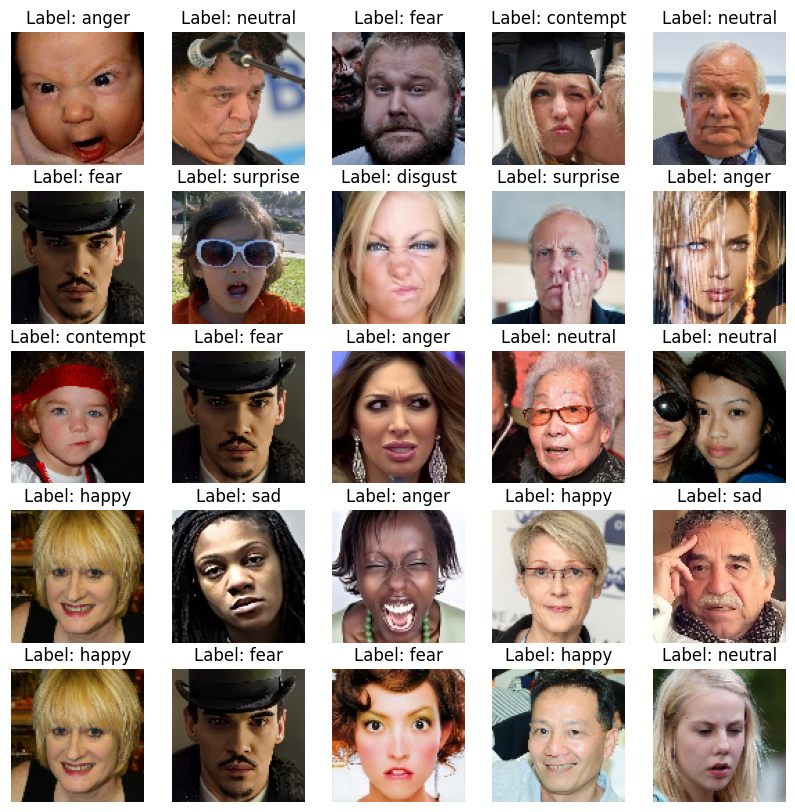

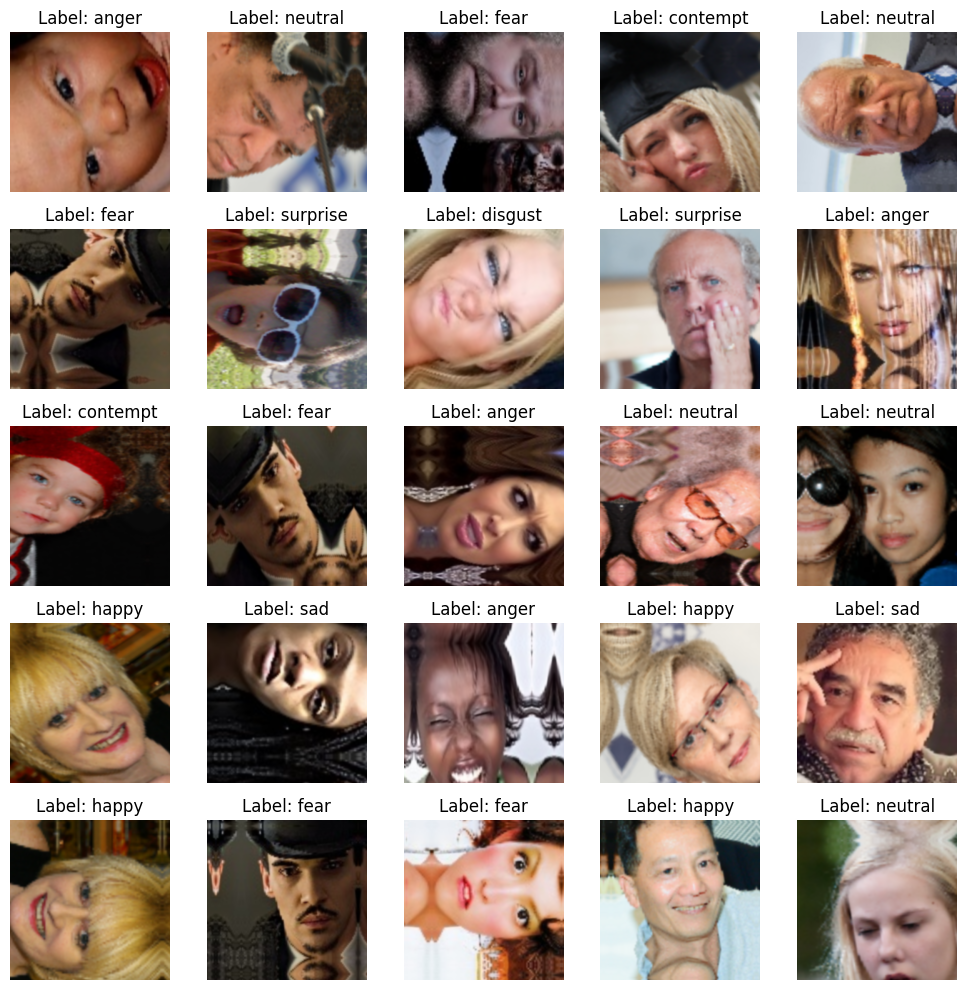

In [153]:
# Sample random images and their indices
image_rand_array = image_train_array[rand]
label_rand_array = label_train_array[rand]

fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))
fig, axes2 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

augmented_image_array = augment_train_images(image_rand_array)

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        image = image_rand_array[index]  # Extract the image
        label = label_rand_array[index]  # Extract the label
        
        # Original pictures (no augmentation layer applied)
        ax1 = axes1[i,j]
        ax1.axis("off")
        # Display the image
        ax1.imshow(image)
        ax1.set_title(f"Label: {label_dict[label]}")
        

        # # Apply the augmentation layer on the image
        # augmented_image = image_augmentation(tf.expand_dims(image, axis=0), training=True)/255

        ax2 = axes2[i,j]
        ax2.axis("off")
        # Display the image
        ax2.imshow(augmented_image_array[index]/255.0)
        ax2.set_title(f"Label: {label_dict[label]}")
        

plt.tight_layout()

In [154]:
image_train_array_augmented = augment_train_images(image_train_array)
image_val_array_processed = vgg16.preprocess_input(image_val_array)
image_test_array_processed = vgg16.preprocess_input(image_test_array)

## numpy array => DataGenerator conversion

In [155]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

   
BATCH_SIZE = 32

# These generator objects will generate 32 data at a time from the specified nparray's
train_gen = DataGenerator(image_train_array_augmented,label_train_array,BATCH_SIZE)
val_gen = DataGenerator(image_val_array_processed,label_val_array,BATCH_SIZE)
test_gen = DataGenerator(image_test_array_processed,label_test_array,BATCH_SIZE)

In [161]:
val_gen = DataGenerator(image_val_array,label_val_array,BATCH_SIZE)
test_gen = DataGenerator(image_test_array,label_test_array,BATCH_SIZE)

In [156]:
preprocessed_images = vgg16.preprocess_input(image_rand_array)

min_val = preprocessed_images.min()
max_val = preprocessed_images.max()

print(f"Pixel value range after preprocessing: [{min_val}, {max_val}]")

Pixel value range after preprocessing: [-123.68000030517578, 151.06100463867188]


## MobileNet-based Model Construction

### MobileNet Base Model

In [162]:
base_model = vgg16.VGG16(input_shape=IMAGE_SIZE+(3,), 
                       include_top=False)
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Full Model

In [163]:
# Create the model
model = keras.Sequential([
    layers.Input(shape=IMAGE_SIZE+(3,)),
    layers.Lambda(vgg16.preprocess_input),              # mobilenet preprocessing function
    base_model,                                         # MobileNet network
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),                    
    layers.Dropout(0.4),                                # To help with generalization
    layers.Dense(100, 
                 activation = "relu",
                #  kernel_regularizer=regularizers.l2(0.01)
    ),

    # layers.BatchNormalization(),                    
    # layers.Dropout(0.4),                                # To help with generalization
    # layers.Dense(100, 
    #              activation = "relu",
    #             #  kernel_regularizer=regularizers.l2(0.01)
    # ),
    
    layers.BatchNormalization(),                    
    layers.Dropout(0.4),                                # To help with generalization
    layers.Dense(num_classes, 
                 activation="softmax",
                #  kernel_regularizer=regularizers.l2(0.01)
    )     # Custom classification layer
])

initial_weights = model.get_weights()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [123]:
len(model.trainable_variables)
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Training

Before any training, the accuracy of the model is fairly poor and is no better than random chance (1/8=12.5%)

In [164]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
loss0, acc0 = model.evaluate(test_gen)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

4/4 [==============================] - 0s 20ms/step - loss: 14.7223 - accuracy: 0.1083
initial loss: 14.72
initial accuracy: 0.11


In [165]:
# Intitial training with frozen base model
initial_lr = 0.0005
initial_batch_size = 32
initial_epochs = 20

model.set_weights(initial_weights)

# # Learning rate scheduler
# initial_lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_lr,
#     decay_steps=1000,
#     decay_rate=0.5
# )
base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
# model.summary()

history_initial = model.fit(train_gen,
                            epochs=initial_epochs,
                            validation_data=val_gen,
                            verbose=1)

Epoch 1/20
20/20 [==============================] - 3s 127ms/step - loss: 3.1920 - accuracy: 0.1111 - val_loss: 9.8940 - val_accuracy: 0.0588
Epoch 2/20
20/20 [==============================] - 2s 120ms/step - loss: 2.8410 - accuracy: 0.1650 - val_loss: 8.3221 - val_accuracy: 0.0882
Epoch 3/20
20/20 [==============================] - 2s 121ms/step - loss: 2.6039 - accuracy: 0.2108 - val_loss: 7.4014 - val_accuracy: 0.1029
Epoch 4/20
20/20 [==============================] - 2s 120ms/step - loss: 2.4336 - accuracy: 0.2108 - val_loss: 6.6194 - val_accuracy: 0.1029
Epoch 5/20
20/20 [==============================] - 2s 120ms/step - loss: 2.3731 - accuracy: 0.2533 - val_loss: 6.2572 - val_accuracy: 0.1029
Epoch 6/20
20/20 [==============================] - 2s 120ms/step - loss: 2.2016 - accuracy: 0.2565 - val_loss: 5.9904 - val_accuracy: 0.1029
Epoch 7/20
20/20 [==============================] - 2s 120ms/step - loss: 2.0856 - accuracy: 0.2827 - val_loss: 5.7037 - val_accuracy: 0.1029
Epoch 

In [166]:
# Fine tuning by unfreezing some later layers of MobileNet
ftune_lr = 0.000005
ftune_batch_size = 16
ftune_epochs = 50
unfrozen_layer = -20

base_model.trainable = True

for layer in base_model.layers[:unfrozen_layer]:
    layer.trainable = False

# Learning rate scheduler
ftune_lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=ftune_lr,
    decay_steps=1000,
    decay_rate=0.5
)

tf.keras.backend.clear_session()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ftune_lr_scheduler),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()
 
history_fine = model.fit(train_gen,
                         epochs=initial_epochs + ftune_epochs,
                         validation_data=val_gen,
                         initial_epoch=history_initial.epoch[-1],       # Resume from previous training
                         verbose = 1)  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 100)              

KeyboardInterrupt: 

In [23]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
  plt.figure(figsize=(10,5))

  

  # Determine whether history is keras history or a dictionary to appropriately extract the history data
  if isinstance(history, tf.keras.callbacks.History):
    history_data = history.history        # Extract the history dictionary
  else:
    history_data = history                # Assume it's already a dictionary

  # Accuracy of model training and validation vs training epoch
  plt.subplot(1,2,1)
  ylim_acc = [0, max(max(history_data['accuracy']),max(history_data['val_accuracy']))]
  plt.plot(history_data['accuracy'], label = 'Training accuracy')
  plt.plot(history_data['val_accuracy'], label = 'Validation accuracy')
  plt.ylim(ylim_acc)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model accuracy')

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')

  # Loss during model training and validation
  plt.subplot(1,2,2)
  ylim_loss = [0, max(max(history_data['loss']),max(history_data['val_loss']))]
  # print(len(history_data['loss']))
  plt.plot(history_data['loss'], label = 'Training loss')
  plt.plot(history_data['val_loss'], label = 'Validation loss')
  plt.ylim(ylim_loss)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

  print(f"The model has a training accuracy of {history_data['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history_data['val_accuracy'][-1]*100:.2f}%")
  return

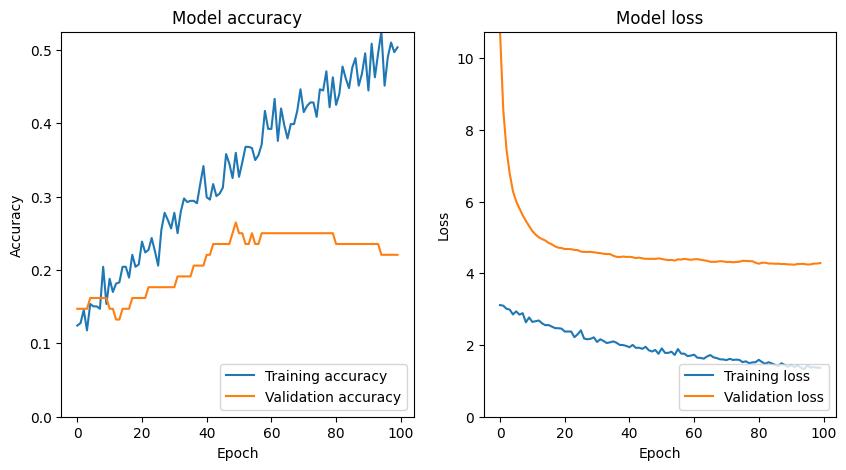

The model has a training accuracy of 50.33%
The model has a validation accuracy of 22.06%


In [128]:
plot_performance(history_initial)

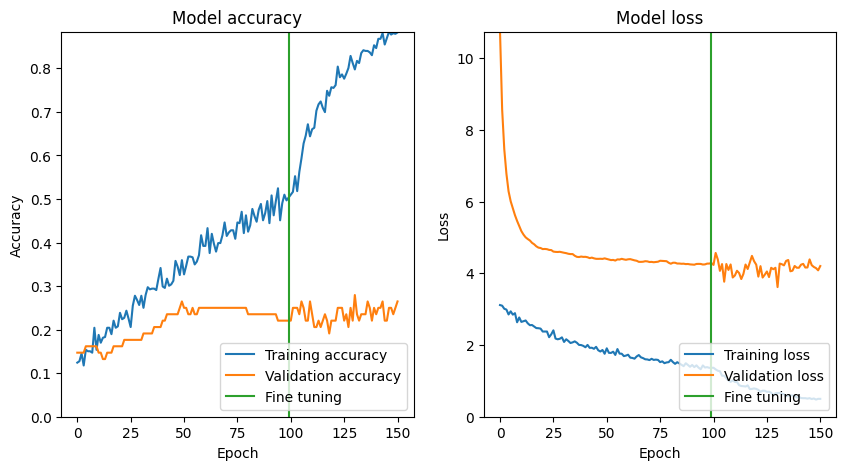

The model has a training accuracy of 88.24%
The model has a validation accuracy of 26.47%


In [130]:
combined_history = {
    'accuracy': history_initial.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history_initial.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history_initial.history['loss'] + history_fine.history['loss'],
    'val_loss': history_initial.history['val_loss'] + history_fine.history['val_loss']
}

plot_performance(combined_history,finetune_epochs=initial_epochs)

## Model evaluation and prediction

### Model evaluation

In [134]:
test_loss, test_acc =  model.evaluate(image_test_array,label_test_array)
print(f"Test accuracy: {test_acc}\n"
      f"Test loss: {test_loss}")

4/4 [==============================] - 0s 20ms/step - loss: 2.0863 - accuracy: 0.2750
Test accuracy: 0.2750000059604645
Test loss: 2.086308240890503


In [143]:
list(label_dict.values())

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

4/4 [==============================] - 0s 115ms/step


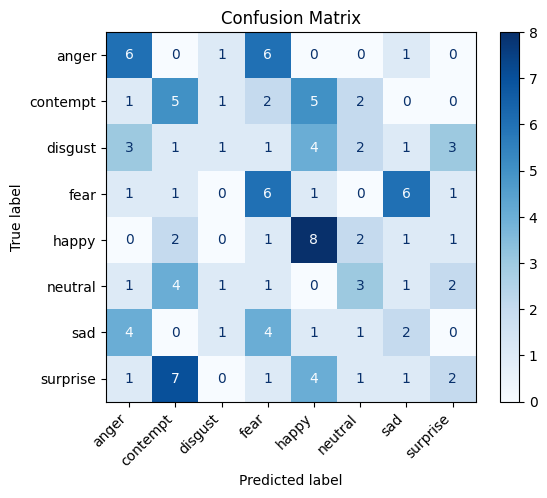

{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}


In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction_array = np.argmax(model.predict(image_test_array), axis=1)

cm = confusion_matrix(label_test_array, prediction_array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(label_dict.values()))
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix")
plt.show()
print(label_dict)

### Model prediction & visualization

1/1 [==============================] - 1s 925ms/step


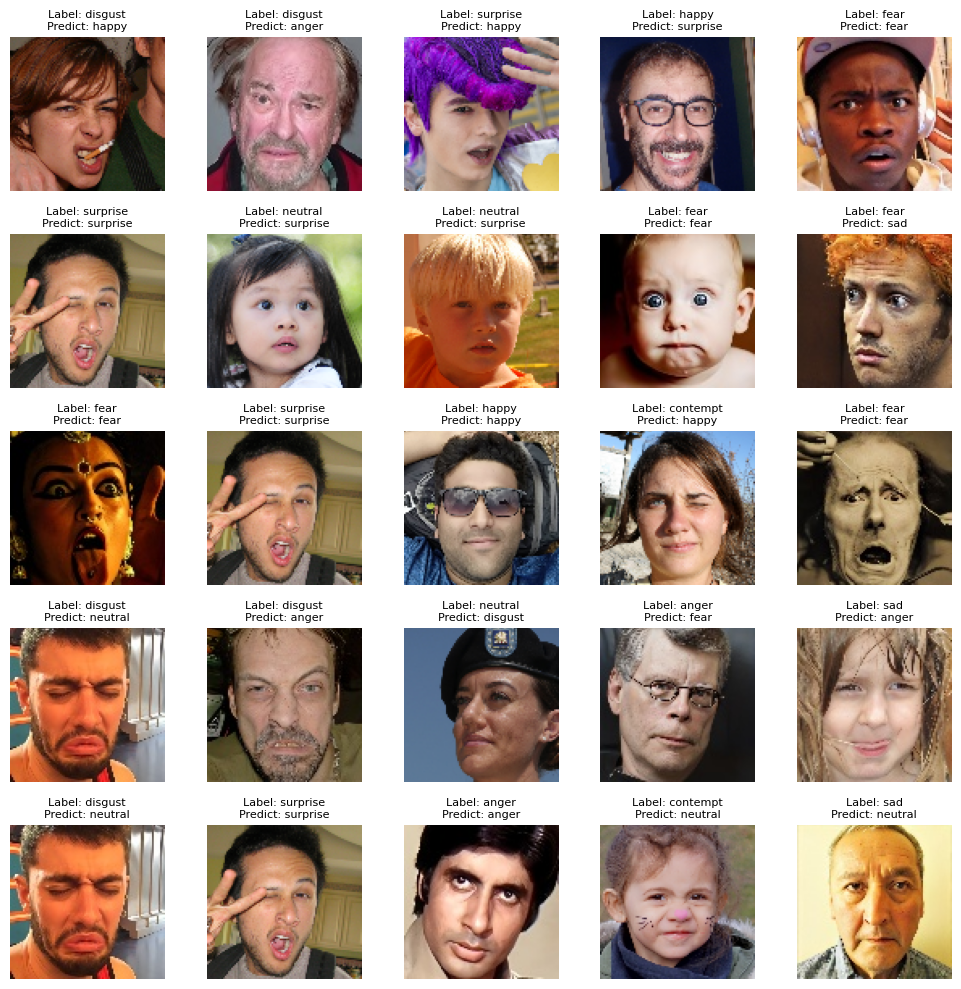

In [136]:
# Sample random images and their indices
num_samples = 25                                                                             # number of samples to be display
num_rows = int(round(sqrt(num_samples))); num_cols = int(num_samples/num_rows)      # number of rows and columns for the subplot
rand = random.randint(num_test,size = (num_samples))                                       # random index for choosing the samples in the dataset

image_test_rand_array = image_test_array[rand]
label_test_rand_array = label_test_array[rand]
prediction_rand_array = np.argmax(model.predict(image_test_rand_array),axis=1)

plt.figure(figsize=(num_rows*2,num_cols*2))
# fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]  # Extract the image
        label = label_test_rand_array[index]  # Extract the label
        prediction = prediction_rand_array[index]

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_dict[label]}\n"
                  f"Predict: {label_dict[prediction]}",
                  fontsize = 8) 

plt.tight_layout()

## Vision Transformer based model from HuggingFace

In [ ]:
# Load Vision Transformer (ViT) model and feature extractor from Hugging Face
from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor, AutoImageProcessor

model_name = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = TFAutoModelForImageClassification.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)


### Data Augmentation layer

In [ ]:
size = (image_processor.size["height"], image_processor.size["width"])
print(size)

train_data_aug = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_aug = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [ ]:
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_aug(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_aug(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch